Adithya Palle \
March 30, 2025 \
Final Project

Jupyter Notebook for running CNN and optical flow models on the stream of data and determining classfication accuracy.

In [1]:
from data_extraction import get_video_data, FIRE_VIDEOS_DATA_PATH
import os

In [2]:
val_fire_videos, val_no_fire_videos = get_video_data(os.path.join(FIRE_VIDEOS_DATA_PATH, "validation"))
test_fire_videos, test_no_fire_videos = get_video_data(os.path.join(FIRE_VIDEOS_DATA_PATH, "test"))


/opt/homebrew/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/torchvision/io/video.py:197: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


In [3]:
from video_model import VideoModel
import random
# Load models


# TODO: initialize your models here


class DummyModel(VideoModel):

    def predict_on_last_frame(self, frames):
        # random prob between 0 and 1
        return random.uniform(0, 1)


my_image_model : VideoModel = DummyModel()
google_net : VideoModel = DummyModel()
alex_net : VideoModel = DummyModel()
optical_flow_model : VideoModel = DummyModel()

In [ ]:
"""
I want each model to give me a list of predictiosn for each frame in the video , so the outputs should be a list of floats in the range [0,1] for each video..

On Validation videos:
    I want to then use this list of booleans to determine Recall (TP / (TP + FN)) over all videos (only have positives in fire videos). 
    and False Alarm Rate (FP / (FP + TN)) over all videos (only have negatives in no fire videos).

    I will then plot a recall vs false alarm rate graph for each model to determine the best threshold.


Then, on testing videos, i will rerun this analysis with the chosen threshold and get the actual Recall and False Alarm Rate for each model.

I will then print thiese out for emach model, and for each model show a video stream of each viedo with a "Fire" or "No Fire" 
text at teh top left of each frame
"""
import torch 
from typing import List


def get_predictions(model : VideoModel, videos : List[torch.Tensor]) -> List[List[float]]:
    """
    Get fire probility predictions for each frame in the video.
    Args:
        model (VideoModel): The model to use for predictions.
        videos (List[torch.Tensor]): List of videos to predict on.
    Returns:
        List[float]: List of predictions for each frame in the video.
    """
    predictions = []
    for video in videos:
        predictions.append(model.predict_on_full_video(video))

    return predictions


In [5]:

val_fire_predictions = get_predictions(my_image_model, val_fire_videos)
val_no_fire_predictions = get_predictions(my_image_model, val_no_fire_videos)




def get_recall(predictions_on_fire_video : List[List[float]], threshold : float) -> float:
    """
    Get recall for the model predictions using the given threshold.
    Args:
        predictions (List[List[float]]): List of predictions for each frame in a video where all frames are positives.
        threshold (float): The threshold to use for determining fire.
    Returns:
        float: The recall for the model predictions.
    """
    tp = 0
    fn = 0
    for pred in predictions_on_fire_video:
        for p in pred:
            if p >= threshold:
                tp += 1
            else:
                fn += 1

    return tp / (tp + fn)


def get_false_posiive_rate(predictions_on_nofire_video : List[List[float]], threshold : float) -> float:
    """
    Get false positive rate for the model predictions using the given threshold.
    Args:
        predictions (List[List[float]]): List of predictions for each frame in a video where all frames are negatives.
        threshold (float): The threshold to use for determining fire.
    Returns:
        float: The false positive rate for the model predictions.
    """
    fp = 0
    tn = 0
    for pred in predictions_on_nofire_video:
        for p in pred:
            if p >= threshold:
                fp += 1
            else:
                tn += 1

    return fp / (fp + tn)





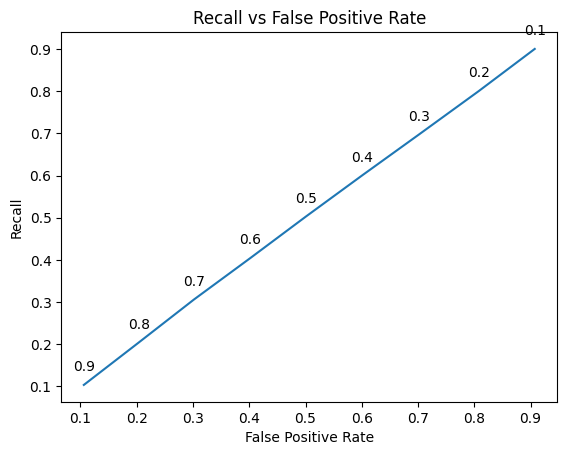

In [6]:
# use recall and FPR curve to determine best threshold for binarizing predictions
recalls = []
fprs = []
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # threshold above which a prediction probabiltiy is considered fire
for threshold in thresholds:
    recall = get_recall(val_fire_predictions, threshold)
    false_positive_rate = get_false_posiive_rate(val_no_fire_predictions, threshold)
    recalls.append(recall)
    fprs.append(false_positive_rate)


# plot recall vs false positive rate
import matplotlib.pyplot as plt
plt.plot(fprs, recalls)

# add point lables with threshold
for i, txt in enumerate(thresholds):
    plt.annotate(txt, (fprs[i], recalls[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Recall vs False Positive Rate')
plt.show()

In [10]:
best_threshold = 0.5 # TODO:  manually choose the best threshold based on the plot


# get results on test videos
test_fire_predictions = get_predictions(my_image_model, test_fire_videos)
test_no_fire_predictions = get_predictions(my_image_model, test_no_fire_videos)
test_recall = get_recall(test_fire_predictions, best_threshold)
test_fpr = get_false_posiive_rate(test_no_fire_predictions, best_threshold)
print("Test Recall: ", test_recall)
print("Test False Positive Rate: ", test_fpr)

Test Recall:  0.496551724137931
Test False Positive Rate:  0.49737195941816403


In [13]:
# display video stream with fire or no fire text for firest video of each type in test set
# TODO: save these videos to files
import cv2
import numpy as np
for i,frame in enumerate(test_fire_videos[0]):

    frame = np.array(frame)
    # convert to BGR
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)


    cv2.putText(frame, "Fire" if test_fire_predictions[0][i] >= threshold else "No Fire", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("Fire Video", frame)
    cv2.waitKey(30)
for i, frame in enumerate(test_no_fire_videos[0]):
    frame = np.array(frame)
    # convert to BGR
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    cv2.putText(frame, "Fire" if test_no_fire_predictions[0][i] >= threshold else "No Fire", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("No Fire Video", frame)
    cv2.waitKey(30)
cv2.destroyAllWindows()

/var/folders/1b/hwf75tz14fsffs3nqgyylfy80000gn/T/ipykernel_9130/324373332.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  frame = np.array(frame)
/var/folders/1b/hwf75tz14fsffs3nqgyylfy80000gn/T/ipykernel_9130/324373332.py:16: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  frame = np.array(frame)
